In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pymc3 as pm

In [4]:
with open('seasons.pickle') as f:
    seasons = pickle.load(f)
for year, season in seasons.iteritems():
    print year,
    season.load_scores()

with open('season2018.pickle') as f:
    season18 = pickle.load(f)
season18.load_scores()

events = {}
for season in seasons.values():
    events.update(season.event_dict)
events.update(season18.event_dict)

2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017


In [7]:
skaters = {}
for discipline in ('men', 'ladies', 'pairs', 'dance'):
    skaters[discipline] = pd.read_csv('pd_data/results_nowd_nofra15_' + discipline + '.csv')

In [119]:
pairs18 = []
for event in season18.events:
    discipline = event.disciplines[2]
    segment = discipline.segments[1]
    for scorecard in segment.scorecards:
        pairs18.append({
            'Event': event.name,
            'Name': scorecard.skater.name,
            'Nation': scorecard.skater.country,
            'Points': scorecard.total_score,
            'Free PCS': scorecard.pcs,
            'Free TES': scorecard.tes
        })
pairs18 = pd.DataFrame(pairs18)

In [8]:
pairs_comp_type = skaters['pairs']

In [25]:
pairs_comp_type['is_gp'] = pairs_comp_type.apply(
    lambda row: 1 if 'gpfra' in row.Event or ('gp' in row.Event and 'gpf' not in row.Event) else 0,
    axis=1)

In [26]:
pairs_comp_type['is_ecfc'] = pairs_comp_type.apply(
    lambda row: 1 if row.Event[:2] == 'fc' or row.Event[:2] == 'ec' else 0,
    axis=1)

In [27]:
pairs_comp_type['is_champ'] = pairs_comp_type.apply(
    lambda row: 1 if row.Event[:2] == 'wc' or row.Event[:3] == 'owg' or ('gpfra' not in row.Event and 'gpf' in row.Event) 
                else 0,
    axis=1
)

In [33]:
history = pairs_comp_type[pairs_comp_type.Season != 2017]
individual_bests_short = {skater: np.max(map(float, history[history.Name == skater]['Short Score']))
                          for skater in history.Name.get_values()}
have_frees = history[history['Free Rank'] != 'DNQ']
have_frees = have_frees[have_frees['Free Rank'] != 'WD']
individual_bests_free = {skater: np.max(map(float, have_frees[have_frees.Name == skater]['Free Score']))
                         for skater in have_frees.Name.get_values()}
med_short = np.median(individual_bests_short.values())
med_free = np.median(individual_bests_free.values())

In [34]:
individual_bests = {skater: np.max(map(float, history[history.Name == skater].Points))
                    for skater in history.Name.get_values()}
med_points = np.median(individual_bests.values())
med_points

145.33000000000001

In [38]:
data2017 = pairs_comp_type[pairs_comp_type.Season == 2017]
data2017['best_points'] = data2017.apply(
    lambda row: individual_bests.get(row.Name, med_points),
    axis=1
)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [82]:
data2017 = data2017[data2017['Free Rank'] != 'DNQ']
data2017 = data2017[data2017['Free Rank'] != 'WD']

In [92]:
X_gp = data2017.is_gp * data2017.best_points
X_ecfc = data2017.is_ecfc * data2017.best_points
X_champ = data2017.is_champ * data2017.best_points
Y = data2017['Free PCS']

In [93]:
np.sqrt(history.Points.var())

40.208076277696897

In [94]:
with pm.Model() as model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=20)           # intercept
#     alpha_ecfc = pm.Normal('alpha_ecfc', mu=10, sd=20)
#     alpha_champ = pm.Normal('alpha_champ', mu=20, sd=20)
    beta_gp = pm.Normal('beta_gp', mu=0.0, sd=0.1)
    beta_ecfc = pm.Normal('beta_ecfc', mu=0.1, sd=0.1)
    beta_champ = pm.Normal('beta_champ', mu=0.2, sd=0.15)
    beta = pm.Normal('beta', mu=0.1, sd=0.15)
    sigma = pm.HalfNormal('sigma', sd=5)              # score variance
    
    # Expected value of outcome
    mu = (alpha + 
          beta_gp * X_gp + beta_ecfc * X_ecfc + beta_champ * X_champ + beta * data2017.best_points)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [95]:
# fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
# axes[0].scatter(X1, Y)
# axes[1].scatter(X2, Y)
# axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel

In [96]:
with model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:09<00:00, 100.32it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127bbd210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1280a4210>]], dtype=object)

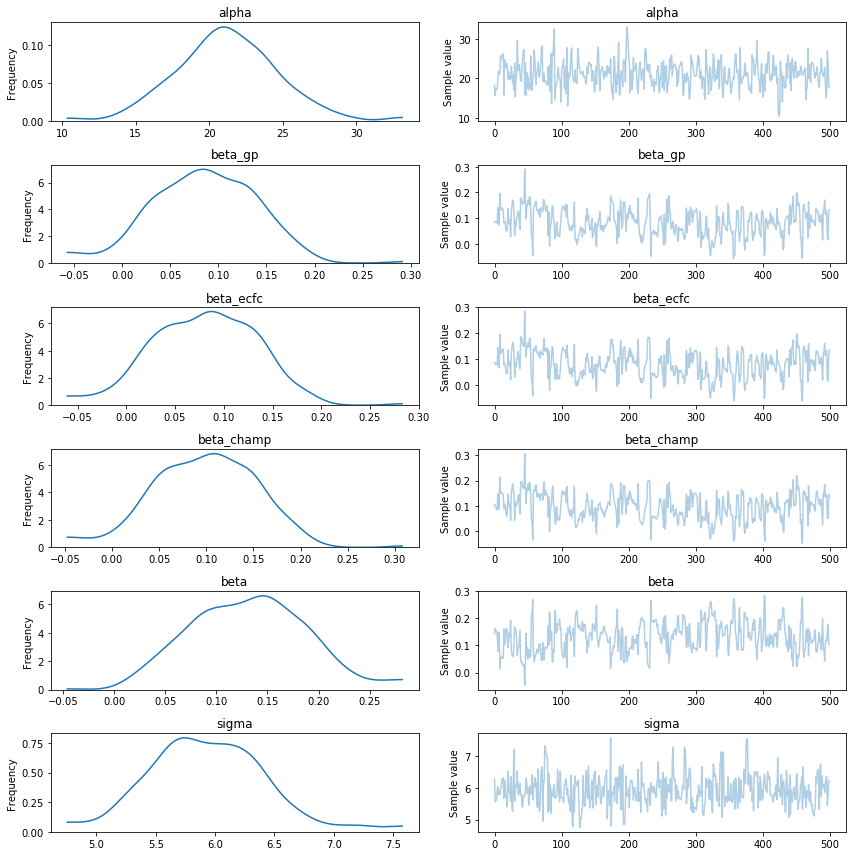

In [97]:
pm.traceplot(trace)

In [98]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  21.211           3.343            0.184            [14.502, 27.354]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  14.774         19.096         21.134         23.322         27.771


beta_gp:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.085            0.052            0.004            [-0.015, 0.178]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.023         0.049          0.085          0.125          0.178


beta_ecfc:

  Mean             SD               MC Error         95% HPD interval
  ---------------

In [113]:
model.alpha + 

AttributeError: 'Model' object has no attribute 'mu'

In [106]:
ppc = pm.sample_ppc(trace, samples=100, model=model, size=100)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: total size of new array must be unchanged

NameError: name 'data' is not defined

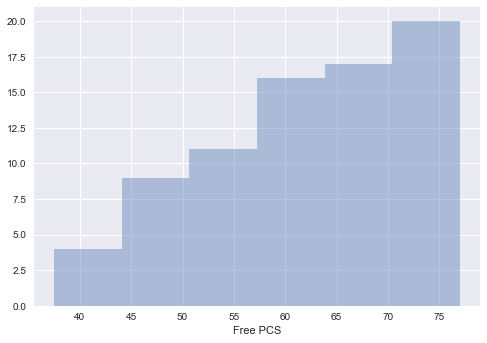

In [111]:
import seaborn as sns
ax = plt.subplot()
sns.distplot(pairs18['Free PCS'], kde=False, ax=ax)
ax.axvline(data.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [ ]:
pm.SkewNormal()

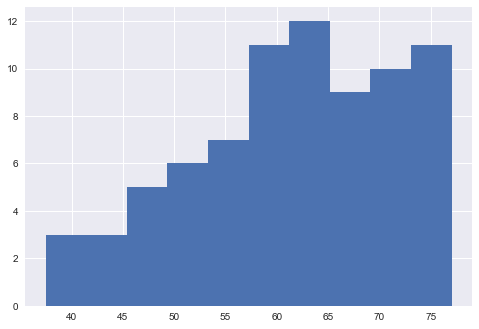

In [117]:
pairs18['Free PCS'].hist()

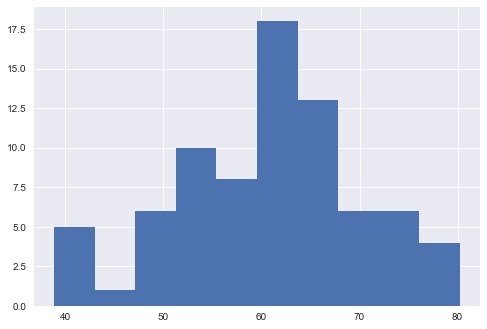

In [120]:
pairs18['Free TES'].hist()

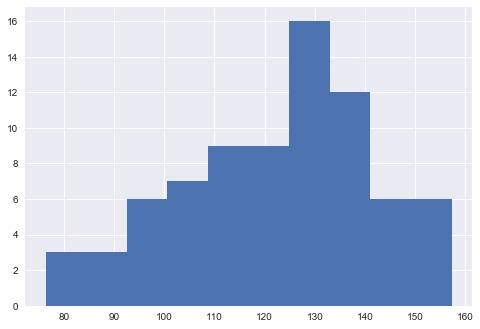

In [116]:
pairs18['Points'].hist()

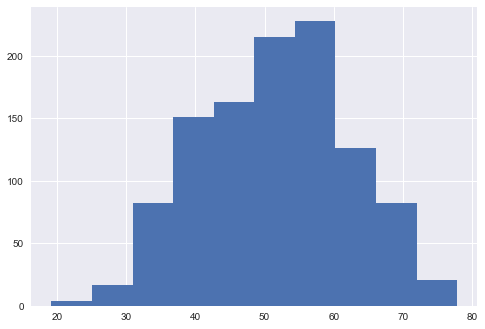

In [115]:
history['Free PCS'].hist()

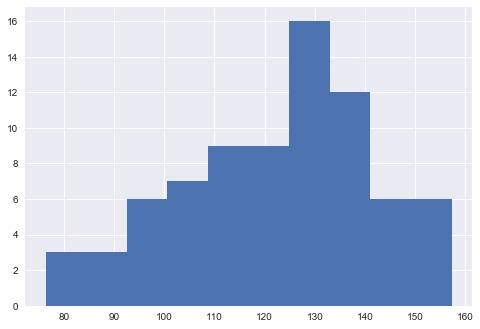

In [121]:
pairs18.Points.hist()

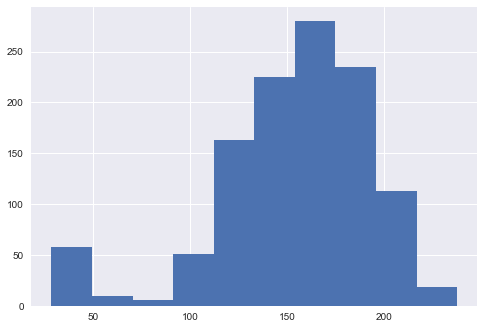

In [122]:
history.Points.hist()